# Outlier Removal and Data Clean-up

This time around, we want to test the theory that the Elbow River is slowly drying up. This is quite plausible, as the primary glacier feeding the Elbow (Rae Glacier) no longer looks like a glacier at all. The City of Calgary [keeps a record](https://data.calgary.ca/Environment/River-Levels-and-Flows/5fdg-ifgr) of the water levels of numerous rivers, creaks, and reservoirs that happen to be nearby. Three of those cover the Elbow River, but all of them have various issues.

* **Elbow River below Glenmore Dam**: This dataset looks good at first, but there's an obvious outlier on January 12th, 2022 and a closer examination reveals a lot of missing data.
* **Elbow River at Sarcee Bridge**: There's no obvious outliers here and very little missing data, but the dataset has a sudden DC offset on April 26, 2018.
* **Elbow River at Bragg Creek**: This series has both negative water levels and about four different DC offsets, though at least it isn't missing much data.

The best dataset for our needs is the last one, unfortunately. Manually cleaning it up would be a pain, but we can take advantage of Bayesian statistics and Stan's features to automatically clean the data for us. Every individual reading gets a parameter, representing our belief in how much of an outlier it is. Readings with an outlier belief less than 50% contribute towards a linear trendline model, while those greater than 50% contribute to an outlier model. 

The obvious disadvantage is that we now have more parameters than data points, but that can be solved by adding further constraints. Outliers should be rare, so tallying up how many there are and drawing from a binomial distribution will encourage the sampler to keep their number small. The outlier distribution is pretty "spikey," with most values hovering around zero, so using an exponential or gamma distribution as a prior will encourage the outliers to fall in line. Unsure of the shape of this distribution? Let Stan handle that for you! 

What about the DC offsets? Stan supports a [positive ordered vector](https://mc-stan.org/docs/reference-manual/vector-and-matrix-data-types.html#positive-ordered-vectors) data type as well as maximum and minimum values, so you can use that to represent the three transition points. Fix the offset of the first span at zero, then add another three variables to represent the offsets of the remaining spans. In the `transformed parameter` section, expand those six variables out into a vector of size `N` which is added to the model.

How about that negative value? Stan can also scrub that away, but it takes a bit of work. You'll need to count the number of non-zero entries, create a new data array of that size, then copy all the non-zero entries from the old array to the new.

# Imports

In [2]:
import arviz as az
from cmdstanpy import install_cmdstan, CmdStanModel

import matplotlib.pyplot as plt
import numpy as np
from os import mkdir
from os.path import exists, isdir

import pandas as pd
import scipy as sp
from tqdm import tqdm as tqdm

In [3]:
# This can take a few minutes, so consider running it now then tabbing back
install_cmdstan()

Installing CmdStan version: 2.32.2
Install directory: /home/hjhornbeck/.cmdstan
CmdStan version 2.32.2 already installed


True

# Global Variables / Methods

In [4]:
data_file  = 'data/calgary_water_levels.csv.bz2'
model_file = 'models/outlier_removal.stan'

# create some useful directories
for directory in ['data','derived','models','posteriors']:
    if not isdir(directory):
        mkdir(directory)

rng = np.random.default_rng(42)

# Data

In [ ]:
# if it hasn't been cached, download it!
if not exists( data_file ):
    
    dataset = pd.read_csv( 'https://data.calgary.ca/api/views/5fdg-ifgr/rows.csv?accessType=DOWNLOAD' )
    dataset.to_csv( data_file, index=False )
else:
    dataset = pd.read_csv( data_file )   # this dataset is huge, so minimize processing    

In [ ]:
cleaned = dataset.drop( ['Station Number','ID','Flow'], axis=1 ).dropna().sort_values( ['Timestamp'] )
cleaned.Timestamp = pd.to_datetime( cleaned.Timestamp )

In [22]:
cleaned['Date'] = cleaned.Timestamp.dt.strftime("%Y-%m-%d")

consolidated = cleaned.groupby(['Station Name','Date']).mean().reset_index()

/tmp/ipykernel_2375006/1817630223.py:3: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [24]:
pd.Categorical( consolidated['Station Name'] ).categories

Index(['Bearspaw Reservoir near Calgary', 'Bow River at Calgary',
       'Bow River near Cochrane', 'Elbow River at Bragg Creek',
       'Elbow River at Sarcee Bridge', 'Elbow River below Glenmore Dam',
       'Glenmore Reservoir at Calgary',
       'Jumpingpound Creek at Township Road 252', 'Nose Creek Above Airdrie',
       'Nose Creek above Airdrie'],
      dtype='object')

In [32]:
target_name = 'Elbow River at Bragg Creek'
target = consolidated[ consolidated['Station Name'] == target_name ]

In [35]:
plt.plot( target.Date, target.Level, '-k', label='data')
plt.title(f'Water level, {target_name}')
plt.xticks([target.Date.min(),target.Date.max()])
plt.ylabel('metres') ; plt.ylim( [0,5] ) ; plt.show()

# Model

In [6]:
stan_code = '''
data {
  int n;       // number of datapoints
  vector[n] X; // the X and Y values of those datapoints
  vector[n] Y;
}
parameters {
 /* TODO */
}
model {
 /* TODO */
}
'''

with open(model_file,'wt') as file:
  file.write(stan_code)

In [7]:
model = CmdStanModel(stan_file=model_file, cpp_options={'STAN_THREADS': 'TRUE'})

11:53:11 - cmdstanpy - INFO - compiling stan file /home/hjhornbeck/school/graduate/presentations/probabilistic_programming_2023/models/template_model.stan to exe file /home/hjhornbeck/school/graduate/presentations/probabilistic_programming_2023/models/template_model
11:53:39 - cmdstanpy - INFO - compiled model executable: /home/hjhornbeck/school/graduate/presentations/probabilistic_programming_2023/models/template_model


In [8]:
data = {'n':len(cleaned), 'X':list(cleaned.Year), 'Y':list(cleaned.Residents)} # must be serializable!

# Sampling

In [9]:
fit = model.sample( data=data )

11:53:39 - cmdstanpy - INFO - CmdStan start processing
Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


11:53:39 - cmdstanpy - ERROR - Error in progress bar initialization:
	'FloatProgress' object has no attribute 'style'
Disabling progress bars for this session


11:53:43 - cmdstanpy - INFO - CmdStan done processing.
11:53:43 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 9 iterations at max treedepth (0.9%)
	Chain 3 had 41 iterations at max treedepth (4.1%)
	Chain 4 had 29 iterations at max treedepth (2.9%)
	Use function "diagnose()" to see further information.


# Diagnostics

In [10]:
print( fit.diagnose() );

Processing csv files: /tmp/tmpf8tmvs1c/template_modeldo6ondkn/template_model-20230602115339_1.csv, /tmp/tmpf8tmvs1c/template_modeldo6ondkn/template_model-20230602115339_2.csv, /tmp/tmpf8tmvs1c/template_modeldo6ondkn/template_model-20230602115339_3.csv, /tmp/tmpf8tmvs1c/template_modeldo6ondkn/template_model-20230602115339_4.csv

Checking sampler transitions treedepth.
79 of 4000 (1.98%) transitions hit the maximum treedepth limit of 10, or 2^10 leapfrog steps.
Trajectories that are prematurely terminated due to this limit will result in slow exploration.
For optimal performance, increase this limit.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete.



In [11]:
fit.summary()

Mean          MCSE        StdDev            5%           50%  \
lp__  -6.662920e+02      0.032898       1.14629 -6.685780e+02 -6.660230e+02   
m      1.728940e+04      7.410140     233.94200  1.689770e+04  1.728430e+04   
b     -3.368270e+07  14732.800000  465322.00000 -3.447050e+07 -3.367270e+07   
sigma  3.366380e+04     82.452400    3113.73000  2.885660e+04  3.345740e+04   

                95%     N_Eff  N_Eff/s    R_hat  
lp__  -6.649740e+02  1214.120  149.744  1.00218  
m      1.768600e+04   996.697  122.928  1.00382  
b     -3.290720e+07   997.558  123.034  1.00379  
sigma  3.894520e+04  1426.110  175.890  1.00178

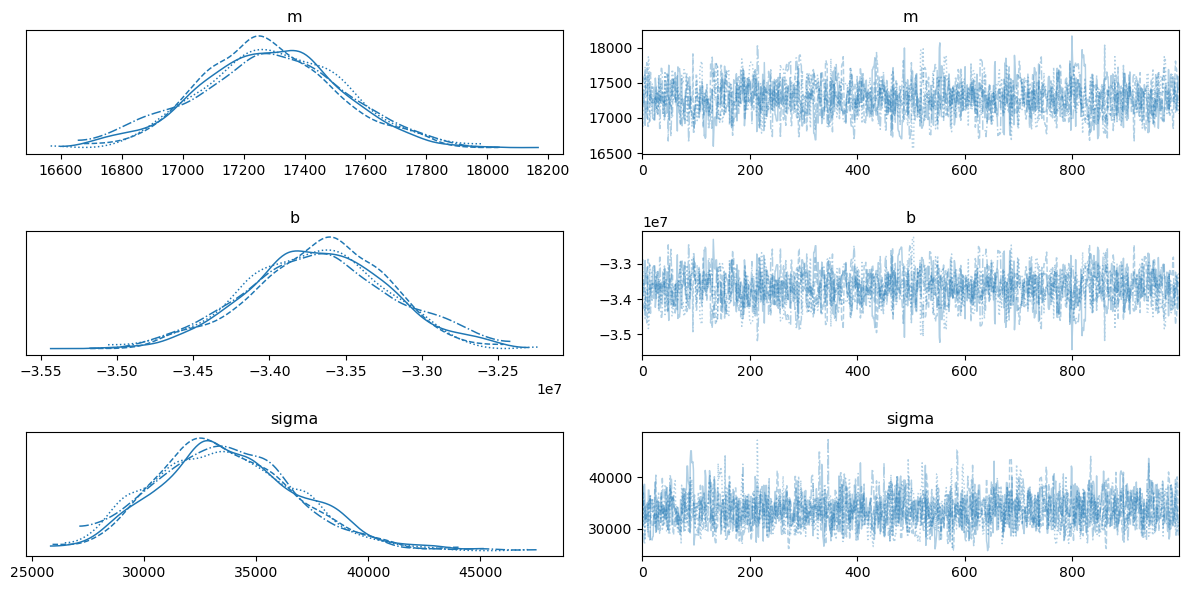

In [12]:
az.plot_trace( fit );
plt.tight_layout()

Exception ignored in: <function tqdm.__del__ at 0x7fe0014a0040>
Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/tqdm/std.py", line 1162, in __del__
    self.close()
  File "/usr/lib/python3/dist-packages/tqdm/notebook.py", line 288, in close
    self.disp(bar_style='danger', check_delay=False)
  File "/usr/lib/python3/dist-packages/tqdm/notebook.py", line 160, in display
    d = self.format_dict
        ^^^^^^^^^^^^^^^^
  File "/usr/lib/python3/dist-packages/tqdm/std.py", line 1476, in format_dict
    'colour': self.colour}
              ^^^^^^^^^^^
  File "/usr/lib/python3/dist-packages/tqdm/notebook.py", line 204, in colour
    return self.container.children[-2].style.bar_color
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'FloatProgress' object has no attribute 'style'


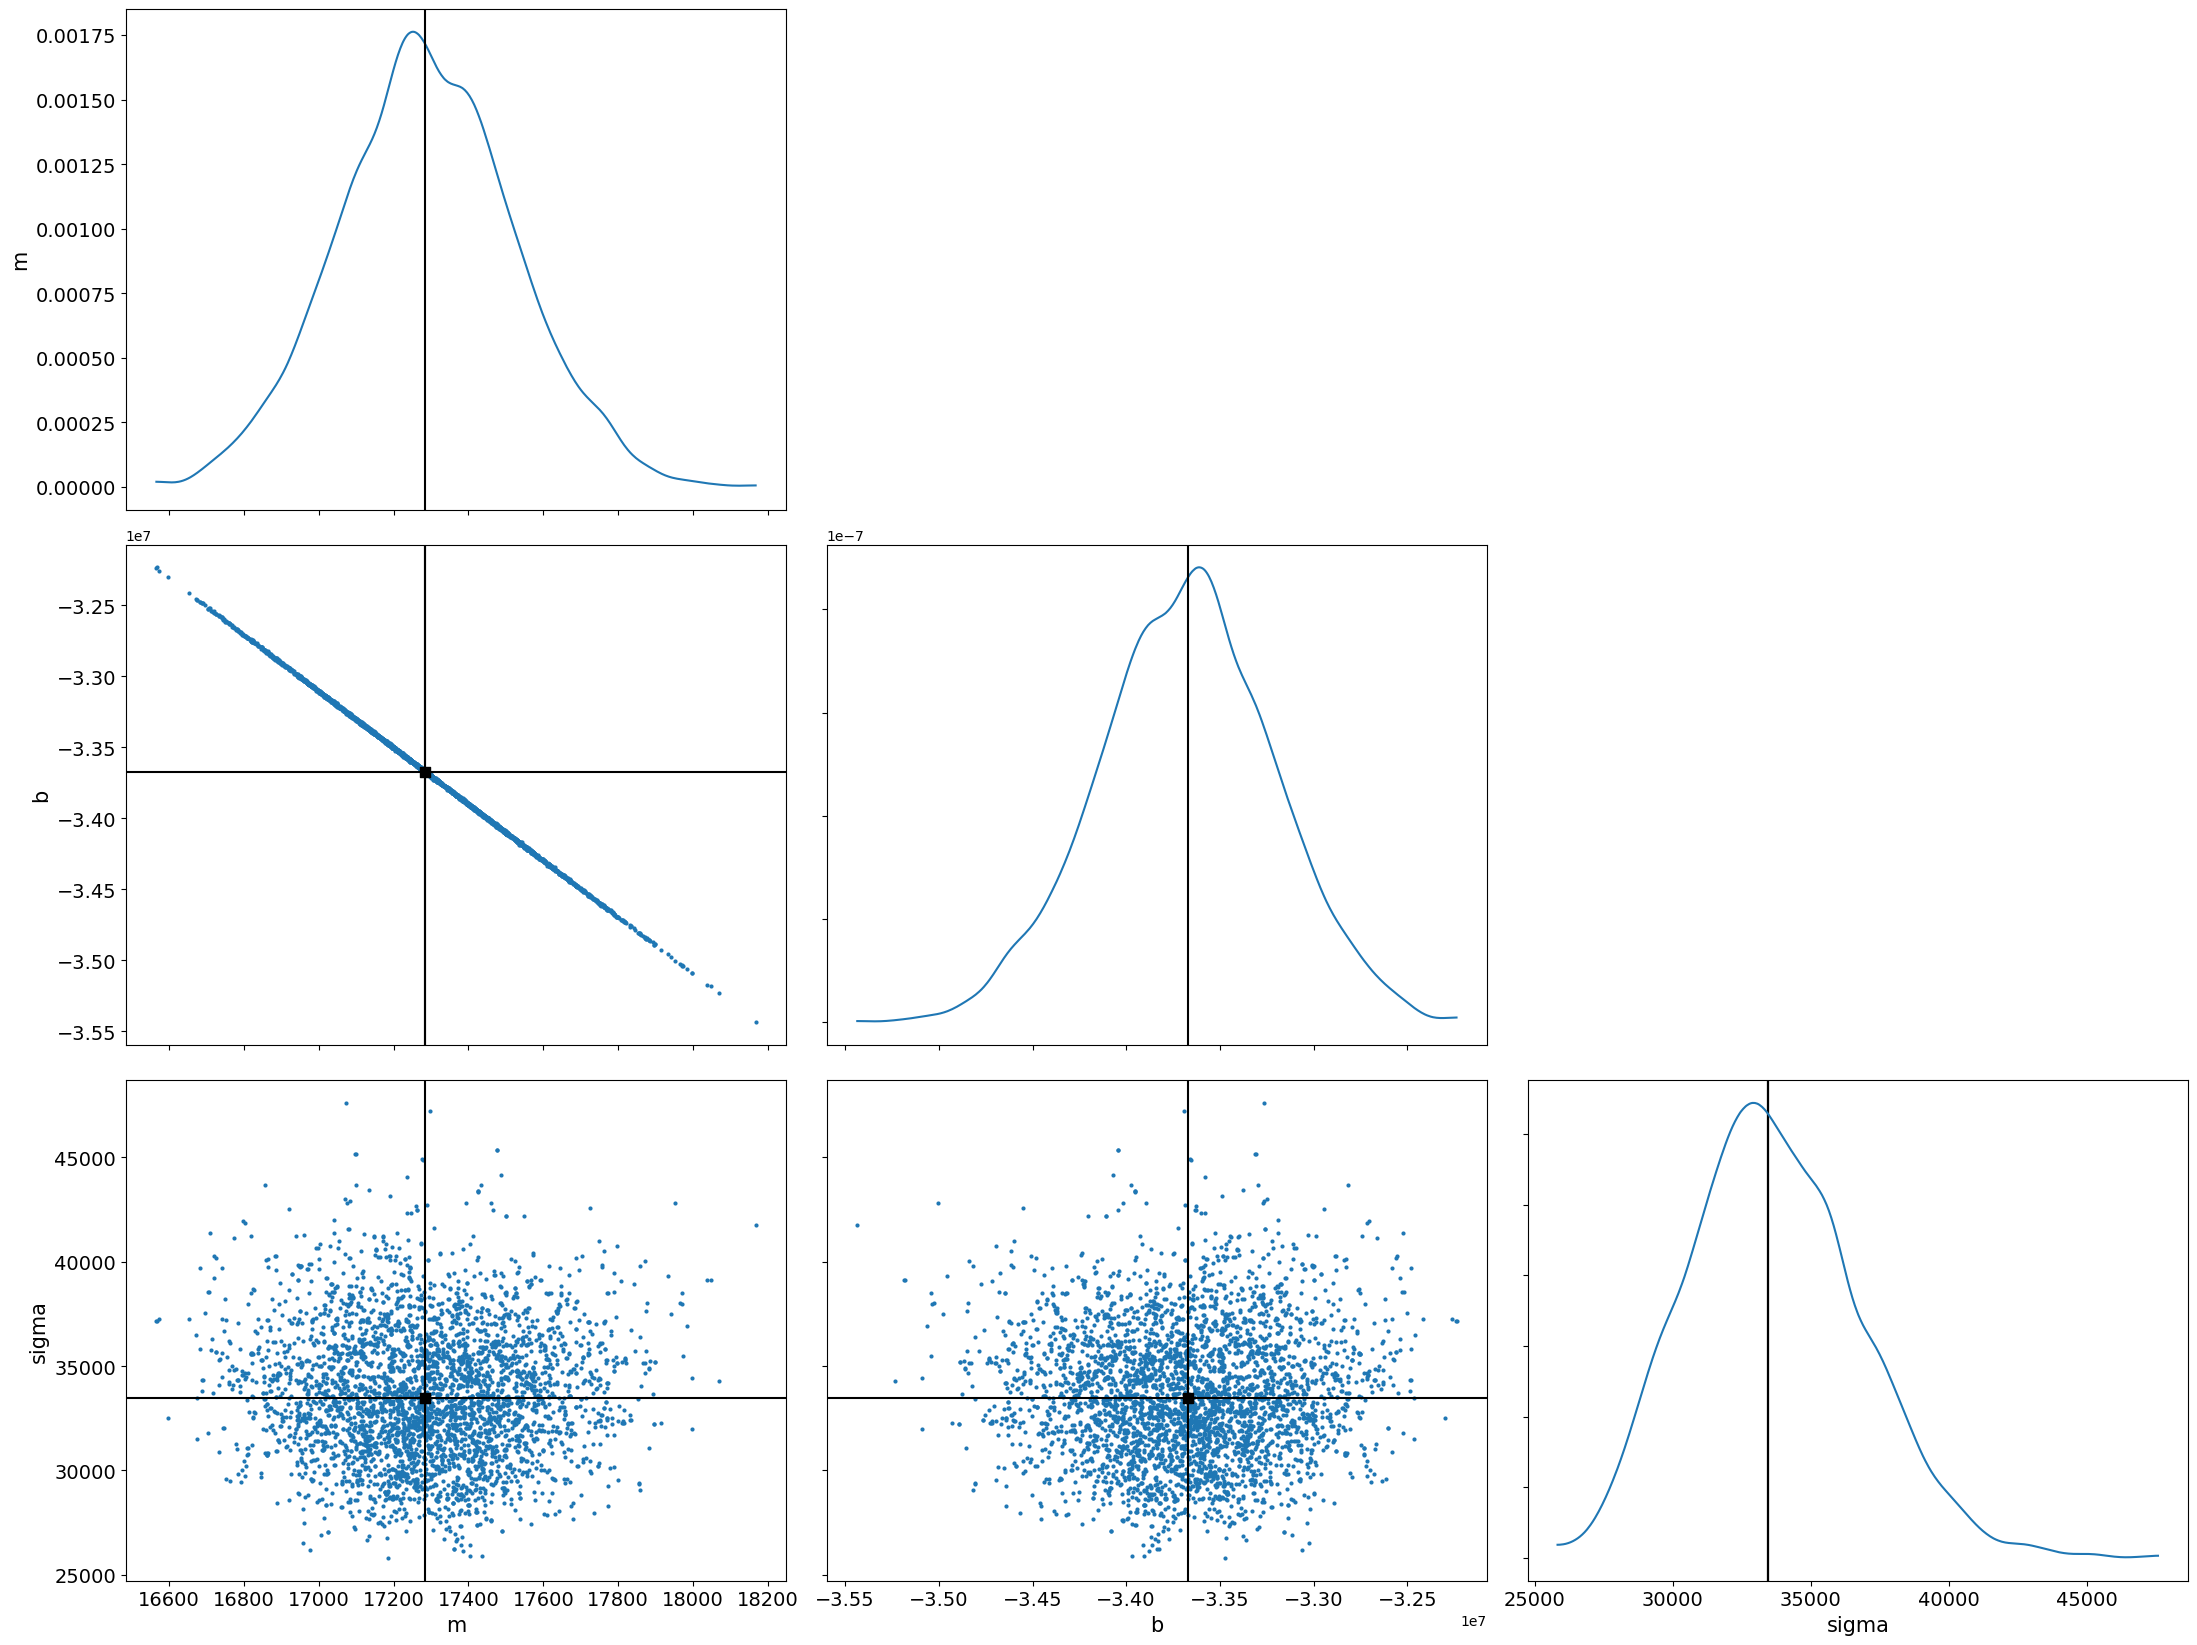

In [15]:
az.plot_pair( fit, marginals=True, point_estimate="median" );
plt.tight_layout()

# Results

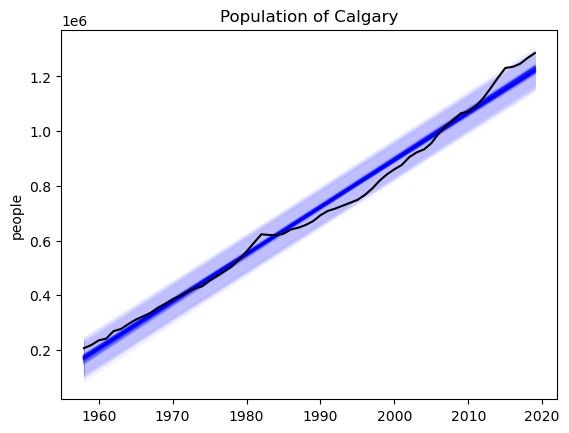

In [14]:
X = np.array( [min(data['X']), max(data['X'])] )

for idx in rng.choice( len(fit.stan_variable('m')), size=64 ):
  model = fit.stan_variable('m')[idx]*X + fit.stan_variable('b')[idx]
  plt.plot( X, model, '-b', alpha=.1 )
  plt.fill_between( X, model - 1.96*fit.stan_variable('sigma')[idx], model + 1.96*fit.stan_variable('sigma')[idx], color='blue', alpha=.005 )

plt.plot( data['X'], data['Y'], '-k', label='data')
plt.title("Population of Calgary")
plt.ylabel('people')
plt.show()